In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, brier_score_loss
from sklearn.model_selection import train_test_split
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Dataset Path
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"

# Load and preprocess dataset
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 🧱 Graph Structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()
# Dataset class with patient-aware sequences
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Split patients (no overlap)
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)
train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df = dataframe[dataframe['patient_id'].isin(test_ids)]

# Dataset creation
train_dataset = WindowedSkeletonDataset(train_df, window_size=120, stride=10)
test_dataset = WindowedSkeletonDataset(test_df, window_size=120, stride=10)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        else:
            return F_loss.sum()

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 101):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")




Epoch 001 | Loss: 32.7099 | Accuracy: 0.6821
Epoch 002 | Loss: 15.8031 | Accuracy: 0.7279
Epoch 003 | Loss: 15.4655 | Accuracy: 0.7274
Epoch 004 | Loss: 15.3458 | Accuracy: 0.7238
Epoch 005 | Loss: 15.8238 | Accuracy: 0.7157
Epoch 006 | Loss: 13.9005 | Accuracy: 0.7289
Epoch 007 | Loss: 13.6141 | Accuracy: 0.7299
Epoch 008 | Loss: 13.7523 | Accuracy: 0.7274
Epoch 009 | Loss: 13.5696 | Accuracy: 0.7279
Epoch 010 | Loss: 13.2538 | Accuracy: 0.7299
Epoch 011 | Loss: 12.7681 | Accuracy: 0.7284
Epoch 012 | Loss: 12.9644 | Accuracy: 0.7258
Epoch 013 | Loss: 12.4404 | Accuracy: 0.7284
Epoch 014 | Loss: 12.3306 | Accuracy: 0.7299
Epoch 015 | Loss: 11.4134 | Accuracy: 0.7345
Epoch 016 | Loss: 11.1415 | Accuracy: 0.7391
Epoch 017 | Loss: 11.0413 | Accuracy: 0.7375
Epoch 018 | Loss: 11.3231 | Accuracy: 0.7340
Epoch 019 | Loss: 10.6917 | Accuracy: 0.7355
Epoch 020 | Loss: 10.9534 | Accuracy: 0.7345
Epoch 021 | Loss: 10.4133 | Accuracy: 0.7360
Epoch 022 | Loss: 10.5863 | Accuracy: 0.7304
Epoch 023 

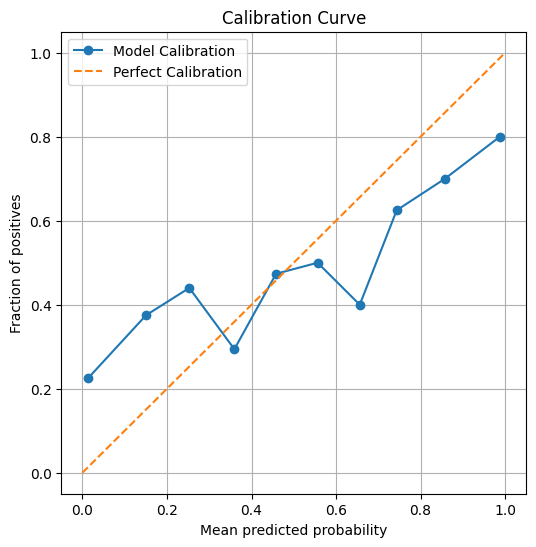

In [6]:
# Evaluation & Calibration
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        out = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        all_probs.append(out)
        all_labels.append(y.item())

# Calibration Curve
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Evaluation - Patient-wise report
model.eval()
patient_results = defaultdict(list)

with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[pid].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Summarize per patient
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Display
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
print(report_df)


   PatientID  Predicted_QoR_class  Actual_QoR_class  valid_percentage  \
0     001-LO                    0                 1             46.94   
1     005-GP                    0                 0             83.33   
2     006-TR                    0                 1              0.00   
3     010-RA                    0                 0             94.12   
4     011-CB                    0                 0             93.75   
5     013-MS                    0                 1             10.53   
6     018-OS                    0                 0            100.00   
7     020-MM                    0                 0             75.00   
8     025-PS                    0                 1             19.05   
9     033-JF                    0                 1             25.00   
10    037-MA                    0                 0             98.75   
11    039-EB                    0                 0            100.00   
12    040-KR                    0                 1